In [11]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import numpy as np
from PIL import Image
import cv2
import scipy.misc
import matplotlib
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D,MaxPooling3D, TimeDistributed, Conv2D, LSTM, SimpleRNN, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

import io
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa

from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, LSTM
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
import pickle
import tensorflow as tf


In [2]:
def load_data():
    data = []
    path = rf"{os.getcwd()}\src\yearly_data"
    for file in os.listdir(path):
        df = pd.read_csv(f'{path}/{file}')
        df.drop(columns=[df.columns[0]], axis=1, inplace=True)
        df.fillna(0.0, inplace=True)
        data.append(df.to_numpy())
    return np.array(data)

data = load_data()


In [3]:
def reshape_data(data):
    data_shifted = data[2:]
    data = data[:-2]
    data = data.reshape((38, 277, 228, 1))
    return data, data_shifted

data, data_shifted = reshape_data(data)

In [4]:
def train_test_split():
    train_dataset = data[:32]
    train_labels = data_shifted[:32]
    test_dataset = data[-6:]
    test_labels = data_shifted[-6:]
    print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
    print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))
    return train_dataset, train_labels, test_dataset, test_labels

train_dataset, train_labels, test_dataset, test_labels = train_test_split()

Training Dataset Shapes: (32, 277, 228, 1), (32, 277, 228)
Validation Dataset Shapes: (6, 277, 228, 1), (6, 277, 228)


In [5]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[i+1:end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), n_steps

In [6]:
x_train, y_train, n_steps = split_sequence(train_dataset, 4)
x_test, y_test, n_steps = split_sequence(test_dataset,4)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (28, 4, 277, 228, 1), (28, 4, 277, 228, 1)
Validation Dataset Shapes: (2, 4, 277, 228, 1), (2, 4, 277, 228, 1)


In [7]:
seq = keras.Sequential(
    [
        keras.Input(shape = (None, *x_train.shape[2:])),
        layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        layers.Conv2D(filters=1, kernel_size=(3,3), activation='relu', padding='same')
    ]
)

seq.compile(loss='mse', optimizer='adam')
seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, 277, 228, 1  160       
                             6)                                  
                                                                 
 conv2d_1 (Conv2D)           (None, None, 277, 228, 3  4640      
                             2)                                  
                                                                 
 conv2d_2 (Conv2D)           (None, None, 277, 228, 6  18496     
                             4)                                  
                                                                 
 conv2d_3 (Conv2D)           (None, None, 277, 228, 1  73856     
                             28)                                 
                                                                 
 conv2d_4 (Conv2D)           (None, None, 277, 228, 6  7

Total params: 194,177
Trainable params: 194,177
Non-trainable params: 0
_________________________________________________________________


In [8]:
len(train_dataset)

32

In [12]:
start_time = time.time()
history = seq.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=10,
    validation_split=0.1
)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/10


25/25 [==============================] - 46s 2s/step - loss: 549.9391 - val_loss: 629.1254
Epoch 2/10
25/25 [==============================] - 44s 2s/step - loss: 527.5956 - val_loss: 553.9365
Epoch 3/10
25/25 [==============================] - 44s 2s/step - loss: 579.0899 - val_loss: 658.9846
Epoch 4/10
25/25 [==============================] - 45s 2s/step - loss: 602.1576 - val_loss: 601.6661
Epoch 5/10
25/25 [==============================] - 45s 2s/step - loss: 534.8611 - val_loss: 632.6984
Epoch 6/10
25/25 [==============================] - 46s 2s/step - loss: 534.4515 - val_loss: 727.7075
Epoch 7/10
25/25 [==============================] - 44s 2s/step - loss: 527.3762 - val_loss: 830.3347
Epoch 8/10
25/25 [==============================] - 44s 2s/step - loss: 543.6761 - val_loss: 1046.4569
Epoch 9/10
25/25 [==============================] - 44s 2s/step - loss: 552.6491 - val_loss: 560.6229
Epoch 10/10
25/25 [==============================] - 43s 2s/step - loss: 538.7269 - val_loss

In [13]:
pred = seq.predict(x_test)

1/1 [==============================] - 1s 849ms/step


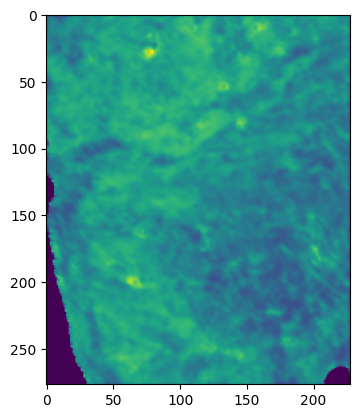

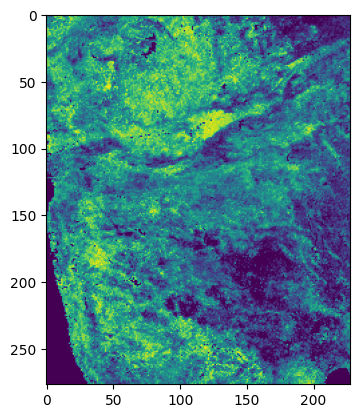

In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf

pred = pred[0][0].reshape(277,228)
yreal = y_test[0][0].reshape(277,228)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)

In [15]:
pickle.dump(seq, open(rf"{os.getcwd()}/models/conv2d/conv2d.pkl", "wb"))
np.save(rf"{os.getcwd()}/models/conv2d/conv2d.npy", history.history)
seq.save(rf"{os.getcwd()}/models/conv2d/conv2d.h5")
model = load_model(rf"{os.getcwd()}/models/conv2d/conv2d.h5")
history_conv2 = np.load(rf"{os.getcwd()}/models/conv2d/conv2d.npy",allow_pickle=True).item()
history_conv2.keys()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\conv2d_5
......vars
.........0
.........1
...layers\conv2d_6
......vars
.........0
.........1
...layers\conv2d_7
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........29
.........3
.........30
.........31
.........32
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                

dict_keys(['loss', 'val_loss'])

In [19]:
prediction = seq.predict(x_test)

1/1 [==============================] - 1s 669ms/step


In [20]:
model = seq
from sklearn.metrics import r2_score

test_r2_scores = []
test_mae = []
test_mse = []
for i in range(len(test_labels)):
    pred = prediction[0][1].reshape(277,228)
    y_real = test_labels[i].reshape(277,228)
    r2 = r2_score(y_real,pred)
    test_r2_scores.append(r2)
    error = (pred - y_real).reshape(277*228)
    mae = sum(abs(error))/len(error)
    test_mae.append(mae)
    mse = np.mean((error) ** 2)
    test_mse.append(mse)


print("Training Time : Conv2D : ", training_time)
print("R2 Score for Conv2D : ", sum(test_r2_scores)/len(test_r2_scores))
print("MSE for Conv2D : ", sum(test_mse)/len(test_mse))
print("MAE Score for Conv2D : ", sum(test_mae)/len(test_mae))

Training Time : RF :  444.6426396369934
R2 Score for RF :  -1.3194186274406603
MSE for RF :  984.9761800729956
MAE Score for RF :  26.310651207977074
